In [1]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
import pandas as pd 
import pydot
import graphviz
import numpy as np 
import seaborn as sns
import random 
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split, KFold
from sklearn import preprocessing

tfku= tf.keras.utils
tfk = tf.keras
tfkl = tf.keras.layers

Num GPUs Available:  1


In [2]:
BATCH_SIZE = 32
SHAPE = (4096, 23)
BLOCK_SHAPE = (64, 23)
EPOCHS = 30
VARIABLES = 23
NFOLD = 5 
STEPS_PER_EPOCH = 200
ID = 37

In [3]:
if ID == 28:
    file='D:/Document/DSCI-601/NGAFID/NGAFID_MC_C28.csv'
elif ID == 37:
    file='D:/Document/DSCI-601/NGAFID/NGAFID_MC_C37.csv'
else:
    print('Invalid ID')
df_test = pd.read_csv(file, nrows=100)
float_cols = [c for c in df_test if df_test[c].dtype == "float64"]
float32_cols = {c: np.float16 for c in float_cols}

df = pd.read_csv(file, dtype=float32_cols, engine='c')
df['id'] = df.id.astype('int32')
df = df.dropna()

In [4]:
sources = df[['id', 'plane_id', 'split', 'date_diff', 'before_after']].drop_duplicates()
sources.loc[: , ['split', 'before_after', 'id']].groupby(['split', 'before_after']).count()

id
split before_after     
0     0             318
      1             224
1     0             246
      1             171
2     0             323
      1             252
3     0             256
      1             162
4     0             270
      1             167

In [5]:
input_columns = ['volt1',
 'volt2',
 'amp1',
 'amp2',
 'FQtyL',
 'FQtyR',
 'E1 FFlow',
 'E1 OilT',
 'E1 OilP',
 'E1 RPM',
 'E1 CHT1',
 'E1 CHT2',
 'E1 CHT3',
 'E1 CHT4',
 'E1 EGT1',
 'E1 EGT2',
 'E1 EGT3',
 'E1 EGT4',
 'OAT',
 'IAS',
 'VSpd',
 'NormAc',
 'AltMSL']

In [6]:
preprocess = preprocessing.MinMaxScaler()
preprocess.fit(df.loc[:, input_columns].sample(100000, random_state = 0 ))
org_value = df.loc[:, input_columns].values
res = preprocess.transform(org_value)
for i, col in enumerate(input_columns):
    df.loc[:, col] = res[:, i]

D:\Python-Anaconda\envs\tf\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


In [7]:
def get_dataset(df): 

    ids = df.id.unique()

    sensor_datas = []
    afters = [] 

    for id in ids: 
        sensor_data = df[df.id == id].iloc[-SHAPE[0]:, :23].values

        sensor_data = np.pad(sensor_data, [[0, SHAPE[0]- len(sensor_data)], [0,0]])

        sensor_data = tf.convert_to_tensor(sensor_data, dtype = tf.float32) 

        after = df[df.id == id]['before_after'].iloc[0]

        sensor_datas.append(sensor_data)
        afters.append(after)


    sensor_datas = tf.stack(sensor_datas)
    afters = np.stack(afters)

    ds = tf.data.Dataset.from_tensor_slices( (sensor_datas, afters))
    
    return ds

In [8]:
def slice_random(x, y):
    start = tf.random.uniform(shape=[], minval=0, maxval=4096-BLOCK_SHAPE[0], dtype=tf.int64)
    x = x[start: start + BLOCK_SHAPE[0]]
    x = tf.reshape(x, (BLOCK_SHAPE))
    return x, y 

In [9]:
def shift_random(x, y):
    x = tf.pad(x, [[64, 64], [0,0]])    
    start = tf.random.uniform(shape=[], minval=0, maxval=64, dtype=tf.int64)
    x = x[start: start + SHAPE[0]]
    x = tf.reshape(x, (SHAPE[0], 23))
    return x, y

In [10]:
def fix_type(x, y):

    return tf.cast(x, tf.float32), tf.cast(y, tf.float32)

In [11]:
def prepare_for_training(ds, shuffle = False, repeat = False, predict= True):
    
    ds = ds.map(fix_type)
    ds = ds.map(slice_random)

    ds = ds.shuffle(512) if shuffle else ds 
    ds = ds.repeat() if repeat else ds 
    ds = ds.batch(BATCH_SIZE, drop_remainder=True)

    if not predict: 
        ds = ds.map(lambda x, y : (x, x) ) 
    else: 
        ds = ds.map(lambda x, y : (x, tf.reshape(y, (-1, 1))) )
         
    return ds

In [12]:
def get_train_and_val_for_fold(folded_datasets, fold):
    predict = True

    train = []
    for i in range(NFOLD-1): 
        if i == fold:
            val_ds = folded_datasets[i][0].concatenate(folded_datasets[i][1])
        else: 
            train.append(folded_datasets[i][0])
    
    test_ds = folded_datasets[4][0].concatenate(folded_datasets[4][1])
    
    train_ds = None
    for ds in train: 
        train_ds = ds if train_ds is None else train_ds.concatenate(ds)

    test_ds = prepare_for_training(test_ds, shuffle=False)
    train_ds = prepare_for_training(train_ds, shuffle=True, repeat = True)
    val_ds = prepare_for_training(val_ds, shuffle=False)
    
    return train_ds, val_ds, test_ds

In [13]:
folded_datasets = []

for i in range(NFOLD):
    after = get_dataset(df[(df.split == i) & (df.before_after == 1)])
    before = get_dataset(df[(df.split == i) & (df.before_after == 0)])
    folded_datasets.append((after, before))

In [14]:
def Autoencoder():
    encoder = tfk.Sequential([
        tfkl.InputLayer(input_shape=BLOCK_SHAPE, name = 'input'),
        tfkl.Conv1D(filters=64, kernel_size=7, padding="same", strides=2, activation="relu"),
        tfkl.Dropout(0.2),
        tfkl.Conv1D(filters=64, kernel_size=7, padding="same", strides=2, activation="relu"),
        tfkl.Dropout(0.2),
        tfkl.Conv1D(filters=64, kernel_size=7, padding="same", strides=2, activation="relu"),
        tfkl.Dropout(0.2),
        tfkl.Conv1D(filters=64, kernel_size=7, padding="same", strides=2, activation="relu"),
        tfkl.Dropout(0.2),
    ], name = 'encoder')
    
    decoder = tfk.Sequential([
        tfkl.Conv1DTranspose(filters=64, kernel_size=7, padding="same", strides=2, activation="relu"),
        tfkl.Conv1DTranspose(filters=64, kernel_size=7, padding="same", strides=2, activation="relu"),       
        tfkl.Conv1DTranspose(filters=64, kernel_size=7, padding="same", strides=2, activation="relu"),
        tfkl.Conv1DTranspose(filters=64, kernel_size=7, padding="same", strides=2, activation="relu"),
        tfkl.Dense(1, activation='sigmoid')
    ],name = 'decoder')
    
    model = tfk.Model(inputs=encoder.inputs, outputs=decoder(encoder.outputs[0]))
    model.encdoer = encoder
    
    return model

In [15]:
def Conv1D():
    model = tfk.Sequential([
        tfk.Input(shape=BLOCK_SHAPE),
        tfkl.Conv1D(filters=64, kernel_size=7, padding="same", strides=2, activation="relu"),
        tfkl.Dropout(0.2),
        tfkl.Conv1D(filters=64, kernel_size=7, padding="same", strides=2, activation="relu"),
        tfkl.Dropout(0.2),
        tfkl.Conv1D(filters=64, kernel_size=7, padding="same", strides=2, activation="relu"),
        tfkl.Dropout(0.2),
        tfkl.Conv1D(filters=64, kernel_size=7, padding="same", strides=2, activation="relu"),
        tfkl.Dropout(0.2),
        tfkl.GlobalAveragePooling1D(),
        tfkl.Dense(1, activation='sigmoid'),
    ])
    
    return model

In [16]:
cnn1D_encoder_result = {}

for i in range(NFOLD-1):
    autoencoder = Autoencoder()
    tfku.plot_model(
        autoencoder,
        to_file='autoencoder_model.png', dpi=96,
        show_shapes=True, show_layer_names=True,
        expand_nested=False
    )

    autoencoder.compile(optimizer = tfk.optimizers.Adam(learning_rate=1e-6), 
                        metrics = ['accuracy', tfk.metrics.RootMeanSquaredError(),],
                        loss = tfk.losses.MeanSquaredError(reduction= tfk.losses.Reduction.SUM_OVER_BATCH_SIZE)
                       )
    train_dataset, val_dataset, test_dataset = get_train_and_val_for_fold(folded_datasets=folded_datasets,fold = i)   
    
    result = autoencoder.fit(train_dataset, epochs= EPOCHS, steps_per_epoch = STEPS_PER_EPOCH, validation_data= val_dataset,)
    
    cnn1D_encoder_result[i] = result.history

pd.DataFrame(cnn1D_encoder_result)

Epoch 1/30
200/200 [==============================] - 6s 13ms/step - loss: 0.2495 - accuracy: 0.5622 - root_mean_squared_error: 0.4995 - val_loss: 0.2502 - val_accuracy: 0.4744 - val_root_mean_squared_error: 0.5002
Epoch 2/30
200/200 [==============================] - 2s 11ms/step - loss: 0.2475 - accuracy: 0.7608 - root_mean_squared_error: 0.4975 - val_loss: 0.2504 - val_accuracy: 0.4577 - val_root_mean_squared_error: 0.5004
Epoch 3/30
200/200 [==============================] - 2s 12ms/step - loss: 0.2439 - accuracy: 0.8957 - root_mean_squared_error: 0.4938 - val_loss: 0.2511 - val_accuracy: 0.4435 - val_root_mean_squared_error: 0.5011
Epoch 4/30
200/200 [==============================] - 2s 12ms/step - loss: 0.2372 - accuracy: 0.9735 - root_mean_squared_error: 0.4871 - val_loss: 0.2526 - val_accuracy: 0.4376 - val_root_mean_squared_error: 0.5026
Epoch 5/30
200/200 [==============================] - 2s 11ms/step - loss: 0.2254 - accuracy: 0.9972 - root_mean_squared_error: 0.4748 - val

200/200 [==============================] - 2s 8ms/step - loss: 0.0873 - accuracy: 1.0000 - root_mean_squared_error: 0.2954 - val_loss: 0.3541 - val_accuracy: 0.4111 - val_root_mean_squared_error: 0.5950
Epoch 10/30
200/200 [==============================] - 2s 9ms/step - loss: 0.0609 - accuracy: 1.0000 - root_mean_squared_error: 0.2468 - val_loss: 0.3959 - val_accuracy: 0.4111 - val_root_mean_squared_error: 0.6292oss: 0.0637 - accuracy: 1.0000 - root_mean_s
Epoch 11/30
200/200 [==============================] - 2s 9ms/step - loss: 0.0451 - accuracy: 1.0000 - root_mean_squared_error: 0.2123 - val_loss: 0.4296 - val_accuracy: 0.4111 - val_root_mean_squared_error: 0.6554
Epoch 12/30
200/200 [==============================] - 2s 9ms/step - loss: 0.0342 - accuracy: 1.0000 - root_mean_squared_error: 0.1848 - val_loss: 0.4586 - val_accuracy: 0.4111 - val_root_mean_squared_error: 0.6772
Epoch 13/30
200/200 [==============================] - 2s 9ms/step - loss: 0.0283 - accuracy: 1.0000 - root_

Epoch 17/30
200/200 [==============================] - 2s 9ms/step - loss: 0.0159 - accuracy: 1.0000 - root_mean_squared_error: 0.1261 - val_loss: 0.4849 - val_accuracy: 0.4632 - val_root_mean_squared_error: 0.6963
Epoch 18/30
200/200 [==============================] - 2s 9ms/step - loss: 0.0154 - accuracy: 1.0000 - root_mean_squared_error: 0.1241 - val_loss: 0.4906 - val_accuracy: 0.4632 - val_root_mean_squared_error: 0.7004
Epoch 19/30
200/200 [==============================] - 2s 9ms/step - loss: 0.0134 - accuracy: 1.0000 - root_mean_squared_error: 0.1160 - val_loss: 0.4894 - val_accuracy: 0.4632 - val_root_mean_squared_error: 0.6996
Epoch 20/30
200/200 [==============================] - 2s 9ms/step - loss: 0.0124 - accuracy: 1.0000 - root_mean_squared_error: 0.1112 - val_loss: 0.4947 - val_accuracy: 0.4632 - val_root_mean_squared_error: 0.7034
Epoch 21/30
200/200 [==============================] - 2s 9ms/step - loss: 0.0116 - accuracy: 1.0000 - root_mean_squared_error: 0.1077 - val

Epoch 25/30
200/200 [==============================] - 2s 9ms/step - loss: 0.0107 - accuracy: 1.0000 - root_mean_squared_error: 0.1033 - val_loss: 0.5903 - val_accuracy: 0.3894 - val_root_mean_squared_error: 0.7683
Epoch 26/30
200/200 [==============================] - 2s 9ms/step - loss: 0.0093 - accuracy: 1.0000 - root_mean_squared_error: 0.0965 - val_loss: 0.5943 - val_accuracy: 0.3894 - val_root_mean_squared_error: 0.7709
Epoch 27/30
200/200 [==============================] - 2s 9ms/step - loss: 0.0088 - accuracy: 1.0000 - root_mean_squared_error: 0.0937 - val_loss: 0.5995 - val_accuracy: 0.3894 - val_root_mean_squared_error: 0.7742
Epoch 28/30
200/200 [==============================] - 2s 9ms/step - loss: 0.0090 - accuracy: 1.0000 - root_mean_squared_error: 0.0947 - val_loss: 0.6030 - val_accuracy: 0.3894 - val_root_mean_squared_error: 0.7765
Epoch 29/30
200/200 [==============================] - 2s 9ms/step - loss: 0.0083 - accuracy: 1.0000 - root_mean_squared_error: 0.0910 - val

,0,1,2,3
loss,"[0.249509796500206, 0.24745717644691467, 0.243...","[0.248081773519516, 0.24552875757217407, 0.240...","[0.2502467632293701, 0.24906831979751587, 0.24...","[0.24969789385795593, 0.2476775199174881, 0.24..."
accuracy,"[0.5622363090515137, 0.760791003704071, 0.8956...","[0.8065991401672363, 0.9343823194503784, 0.986...","[0.4678320288658142, 0.7693628072738647, 0.941...","[0.5404907464981079, 0.7324267625808716, 0.885..."
root_mean_squared_error,"[0.4995095431804657, 0.49745064973831177, 0.49...","[0.4980780780315399, 0.4955085813999176, 0.490...","[0.5002467036247253, 0.4990674555301666, 0.497...","[0.49969780445098877, 0.49767205119132996, 0.4..."
val_loss,"[0.2501683235168457, 0.250427782535553, 0.2510...","[0.2504463791847229, 0.25098830461502075, 0.25...","[0.25002822279930115, 0.25010085105895996, 0.2...","[0.25026965141296387, 0.25081419944763184, 0.2..."
val_accuracy,"[0.47442626953125, 0.457733154296875, 0.443511...","[0.42792218923568726, 0.41676682233810425, 0.4...","[0.48273780941963196, 0.46613624691963196, 0.4...","[0.45834586024284363, 0.40594953298568726, 0.3..."
val_root_mean_squared_error,"[0.5001682639122009, 0.5004276037216187, 0.501...","[0.5004461407661438, 0.5009873509407043, 0.502...","[0.5000281929969788, 0.50010085105896, 0.50022...","[0.5002695918083191, 0.5008135437965393, 0.501..."


In [17]:
cnnv1D_result = {}

for i in range(NFOLD-1):
    conv1D = Conv1D()
    tfku.plot_model(
        conv1D,
        to_file='conv1D_model.png', dpi=96,
        show_shapes=True, show_layer_names=True,
        expand_nested=False
    )

    conv1D.compile(optimizer = tfk.optimizers.Adam(learning_rate=1e-6), 
                   metrics = ['accuracy', tfk.metrics.RootMeanSquaredError(),],
                   loss = tfk.losses.MeanSquaredError(reduction= tfk.losses.Reduction.SUM_OVER_BATCH_SIZE)
                  )
    train_dataset, val_dataset, test_dataset = get_train_and_val_for_fold(folded_datasets=folded_datasets,fold = i)   
    
    result = conv1D.fit(train_dataset, epochs= EPOCHS, steps_per_epoch = STEPS_PER_EPOCH, validation_data= val_dataset,)
    
    cnnv1D_result[i] = result.history

pd.DataFrame(cnnv1D_result)

Epoch 1/30
200/200 [==============================] - 2s 7ms/step - loss: 0.2021 - accuracy: 0.9961 - root_mean_squared_error: 0.4496 - val_loss: 0.2612 - val_accuracy: 0.4375 - val_root_mean_squared_error: 0.5111
Epoch 2/30
200/200 [==============================] - 1s 7ms/step - loss: 0.1780 - accuracy: 0.9998 - root_mean_squared_error: 0.4219 - val_loss: 0.2691 - val_accuracy: 0.4375 - val_root_mean_squared_error: 0.5188
Epoch 3/30
200/200 [==============================] - 1s 7ms/step - loss: 0.1529 - accuracy: 1.0000 - root_mean_squared_error: 0.3910 - val_loss: 0.2807 - val_accuracy: 0.4375 - val_root_mean_squared_error: 0.5298
Epoch 4/30
200/200 [==============================] - 1s 7ms/step - loss: 0.1268 - accuracy: 1.0000 - root_mean_squared_error: 0.3561 - val_loss: 0.2949 - val_accuracy: 0.4375 - val_root_mean_squared_error: 0.5430
Epoch 5/30
200/200 [==============================] - 1s 7ms/step - loss: 0.1031 - accuracy: 1.0000 - root_mean_squared_error: 0.3211 - val_loss

200/200 [==============================] - 1s 7ms/step - loss: 0.0267 - accuracy: 1.0000 - root_mean_squared_error: 0.1634 - val_loss: 0.4578 - val_accuracy: 0.4111 - val_root_mean_squared_error: 0.6766
Epoch 10/30
200/200 [==============================] - 1s 7ms/step - loss: 0.0213 - accuracy: 1.0000 - root_mean_squared_error: 0.1459 - val_loss: 0.4671 - val_accuracy: 0.4111 - val_root_mean_squared_error: 0.6834
Epoch 11/30
200/200 [==============================] - 1s 7ms/step - loss: 0.0200 - accuracy: 1.0000 - root_mean_squared_error: 0.1415 - val_loss: 0.4848 - val_accuracy: 0.4111 - val_root_mean_squared_error: 0.6963
Epoch 12/30
200/200 [==============================] - 1s 7ms/step - loss: 0.0177 - accuracy: 1.0000 - root_mean_squared_error: 0.1331 - val_loss: 0.4937 - val_accuracy: 0.4111 - val_root_mean_squared_error: 0.7026
Epoch 13/30
200/200 [==============================] - 1s 7ms/step - loss: 0.0159 - accuracy: 1.0000 - root_mean_squared_error: 0.1260 - val_loss: 0.499

200/200 [==============================] - 1s 7ms/step - loss: 0.0170 - accuracy: 1.0000 - root_mean_squared_error: 0.1305 - val_loss: 0.4598 - val_accuracy: 0.4632 - val_root_mean_squared_error: 0.6781
Epoch 18/30
200/200 [==============================] - 1s 7ms/step - loss: 0.0165 - accuracy: 1.0000 - root_mean_squared_error: 0.1283 - val_loss: 0.4699 - val_accuracy: 0.4632 - val_root_mean_squared_error: 0.6855
Epoch 19/30
200/200 [==============================] - 1s 7ms/step - loss: 0.0143 - accuracy: 1.0000 - root_mean_squared_error: 0.1198 - val_loss: 0.4791 - val_accuracy: 0.4632 - val_root_mean_squared_error: 0.6922
Epoch 20/30
200/200 [==============================] - 1s 7ms/step - loss: 0.0125 - accuracy: 1.0000 - root_mean_squared_error: 0.1118 - val_loss: 0.4811 - val_accuracy: 0.4632 - val_root_mean_squared_error: 0.6936
Epoch 21/30
200/200 [==============================] - 1s 7ms/step - loss: 0.0121 - accuracy: 1.0000 - root_mean_squared_error: 0.1102 - val_loss: 0.488

200/200 [==============================] - 1s 7ms/step - loss: 0.0100 - accuracy: 1.0000 - root_mean_squared_error: 0.1001 - val_loss: 0.5738 - val_accuracy: 0.3894 - val_root_mean_squared_error: 0.7575
Epoch 26/30
200/200 [==============================] - 1s 6ms/step - loss: 0.0097 - accuracy: 1.0000 - root_mean_squared_error: 0.0984 - val_loss: 0.5760 - val_accuracy: 0.3894 - val_root_mean_squared_error: 0.7589
Epoch 27/30
200/200 [==============================] - 1s 7ms/step - loss: 0.0104 - accuracy: 1.0000 - root_mean_squared_error: 0.1021 - val_loss: 0.5767 - val_accuracy: 0.3894 - val_root_mean_squared_error: 0.7594
Epoch 28/30
200/200 [==============================] - 1s 7ms/step - loss: 0.0099 - accuracy: 1.0000 - root_mean_squared_error: 0.0995 - val_loss: 0.5792 - val_accuracy: 0.3894 - val_root_mean_squared_error: 0.7610
Epoch 29/30
200/200 [==============================] - 1s 7ms/step - loss: 0.0095 - accuracy: 1.0000 - root_mean_squared_error: 0.0974 - val_loss: 0.582

,0,1,2,3
loss,"[0.2021436095237732, 0.178002268075943, 0.1529...","[0.16334854066371918, 0.13662376999855042, 0.1...","[0.2912309169769287, 0.2664574086666107, 0.242...","[0.2566561698913574, 0.2316497564315796, 0.207..."
accuracy,"[0.99609375, 0.9998437762260437, 1.0, 1.0, 1.0...","[0.9996874928474426, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[0.05671875178813934, 0.23250000178813934, 0.6...","[0.40453124046325684, 0.8481249809265137, 0.98..."
root_mean_squared_error,"[0.4496038258075714, 0.421903133392334, 0.3910...","[0.40416398644447327, 0.369626522064209, 0.333...","[0.5396581292152405, 0.5161951184272766, 0.492...","[0.5066124200820923, 0.4813000559806824, 0.455..."
val_loss,"[0.2612124979496002, 0.26913654804229736, 0.28...","[0.2810634672641754, 0.29867303371429443, 0.31...","[0.2495463341474533, 0.2507007122039795, 0.253...","[0.252252459526062, 0.26021650433540344, 0.268..."
val_accuracy,"[0.4375, 0.4375, 0.4375, 0.4375, 0.4375, 0.437...","[0.4110576808452606, 0.4110576808452606, 0.411...","[0.53125, 0.47242647409439087, 0.4632352888584...","[0.41826921701431274, 0.38942307233810425, 0.3..."
val_root_mean_squared_error,"[0.5110895037651062, 0.5187837481498718, 0.529...","[0.5301541686058044, 0.546509861946106, 0.5645...","[0.4995461404323578, 0.5007001757621765, 0.503...","[0.5022473931312561, 0.5101141929626465, 0.518..."


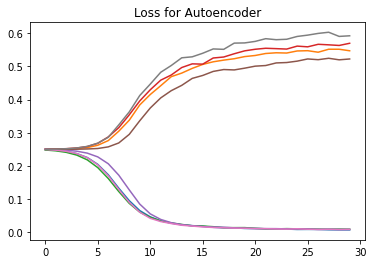

In [18]:
for i in range(NFOLD-1):
    loss = cnn1D_encoder_result[i]['loss']
    val_loss = cnn1D_encoder_result[i]['val_loss']
    plt.plot(loss)
    plt.plot(val_loss)
    plt.title('Loss for Autoencoder')

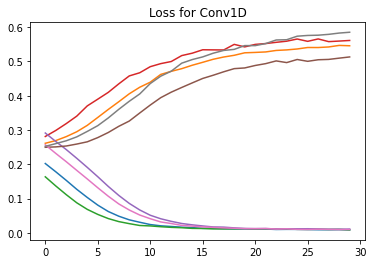

In [19]:
for i in range(NFOLD-1):
    loss = cnnv1D_result[i]['loss']
    val_loss = cnnv1D_result[i]['val_loss']
    plt.plot(loss)
    plt.plot(val_loss)
    plt.title('Loss for Conv1D')

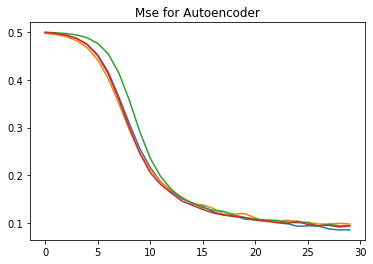

In [20]:
for i in range(NFOLD-1):
    mse = cnn1D_encoder_result[i]['root_mean_squared_error']
    plt.plot(mse)
    plt.title('Mse for Autoencoder')

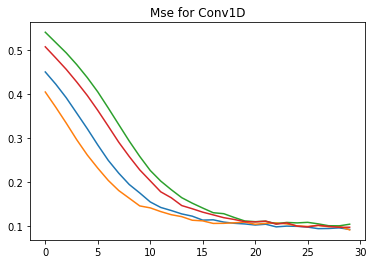

In [21]:
for i in range(NFOLD-1):
    mse = cnnv1D_result[i]['root_mean_squared_error']
    plt.plot(mse)
    plt.title('Mse for Conv1D')

13/13 [==============================] - 0s 2ms/step


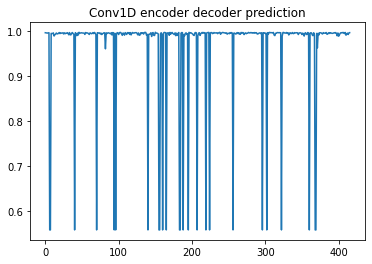

In [22]:
predict = []
cnn1D_enc_predict = autoencoder.predict(test_dataset, verbose = True)
for i in range(len(cnn1D_enc_predict)):
    result = sum(cnn1D_enc_predict[i]) / len(cnn1D_enc_predict[i])
    predict.append(result)

plt.title("Conv1D encoder decoder prediction")    
plt.plot(predict)

13/13 [==============================] - 0s 2ms/step


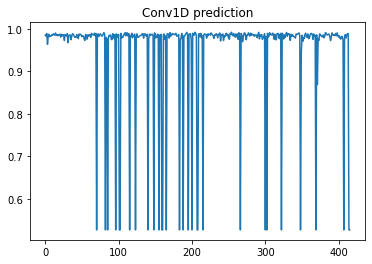

In [23]:
conv1D_predict = conv1D.predict(test_dataset, verbose = True)
plt.title("Conv1D prediction")
plt.plot(conv1D_predict)